In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from matplotlib.cm import get_cmap
from scipy.stats import truncnorm, qmc
from tqdm import tqdm
import sbibm
from sbibm.tasks.gaussian_linear.task import GaussianLinear
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
import seaborn as sns
from itertools import product
import random
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import uniform
from matplotlib import colormaps
import matplotlib.colors as mcolors
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from torch.distributions import Distribution, Uniform, HalfNormal
from torch.distributions.utils import broadcast_all
import math
from ili.utils.distributions_pt import CustomIndependent
import itertools
import pickle
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

sns.set(style="whitegrid", context="paper", font_scale=1.2)

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
n_posterior_samples = 2000

class DistanceEvaluator:
    def __init__(self, simulator, param_ranges, task):
        self.simulator = simulator
        self.param_ranges = param_ranges
        self.task = task
        self.dim = len(param_ranges)
        self.prior_center = np.array([(low + high) / 2 for low, high in param_ranges])
        # Standard deviation per dimension for uniform distribution: (b-a)/sqrt(12)
        self.sigma = np.mean([(high - low) / np.sqrt(12) for low, high in param_ranges])
        self.max_radius = min([(high - low) / 2 for low, high in param_ranges])

    def sample_on_sphere(self, n_points, radius, dim, filter_bounds=True):
        """Sample points uniformly on a sphere of given radius in d dimensions"""
        if radius == 0:
            return np.array([self.prior_center])

        # Generate points from standard normal distribution
        points = np.random.randn(n_points, dim)
        # Normalize to unit sphere
        norms = np.linalg.norm(points, axis=1, keepdims=True)
        points = points / norms
        # Scale to desired radius
        points = points * radius
        # Translate to prior center
        points = points + self.prior_center

        # Conditionally filter points based on flag
        if filter_bounds:
            # Filter points that fall within prior bounds
            valid_points = []
            for point in points:
                if all(self.param_ranges[i][0] <= point[i] <= self.param_ranges[i][1]
                       for i in range(self.dim)):
                    valid_points.append(point)
            return np.array(valid_points)
        else:
            # Return all points, even those outside prior
            return points

    def create_test_points(self, n_points_per_radius=50):
        """Create test points at different distance bins (explicit radius values)"""
        test_points = []
        distance_bins = []
        # Radius-based bins (clearer and more explicit)
        # All radii ≤ 1.0 are within prior bounds
        # 2-sigma extrapolation point tests model's ability to generalize outside prior
        distance_labels = ['center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2sigma-extrap']
        radii = [0.0, 0.25, 0.5, 0.75, 1.0, 2.0 * self.sigma]  # Last one is ~1.15, outside prior

        for radius, label in zip(radii, distance_labels):
            if radius == 0:
                # Center point
                test_points.append(self.prior_center.copy())
                distance_bins.append(label)
            else:
                # Sample points on sphere at this radius
                attempts = 0
                max_attempts = 20  # Increased attempts for better coverage
                points_at_radius = []

                # For extrapolation point (last radius), disable filtering
                use_filter = (label != '2sigma-extrap')

                while len(points_at_radius) < n_points_per_radius and attempts < max_attempts:
                    # Sample more points than needed to account for filtering (only if filtering)
                    sample_count = n_points_per_radius * 3 if use_filter else n_points_per_radius
                    new_points = self.sample_on_sphere(
                        sample_count, radius, self.dim, filter_bounds=use_filter
                    )
                    if len(new_points) > 0:
                        points_at_radius.extend(new_points)
                    attempts += 1

                # Take only the requested number of points
                points_at_radius = points_at_radius[:n_points_per_radius]

                # Add warning if we couldn't get enough points
                if len(points_at_radius) < n_points_per_radius:
                    print(f"Warning: Only got {len(points_at_radius)}/{n_points_per_radius} points for {label} (radius={radius:.3f})")

                for point in points_at_radius:
                    test_points.append(point)
                    distance_bins.append(label)

        return np.array(test_points), np.array(distance_bins)

    def evaluate_all(self, posterior_dict, test_points, n_samples=n_posterior_samples):
        """Evaluate all posteriors including reference"""
        observations = []
        results = {'test_points': test_points}

        # Generate observations
        for theta in tqdm(test_points, desc="Generating observations"):
            x_obs = self.simulator(torch.tensor(theta, dtype=torch.float32))
            observations.append(x_obs)

        results['observations'] = observations

        # Reference posteriors
        ref_samples = []
        for x_obs in tqdm(observations, desc="Reference"):
            ref_post = self.task._get_reference_posterior(observation=x_obs.unsqueeze(0))
            ref_samples.append(ref_post.sample((n_samples,)).cpu().numpy())
        results['Reference'] = ref_samples

        # Learned posteriors
        for name, posterior in posterior_dict.items():
            samples = []
            for x_obs in tqdm(observations, desc=name):
                samples.append(posterior.sample((n_samples,), x_obs).cpu().numpy())
            results[name] = samples

        return results

    def c2st(self, X1, X2):
        """C2ST score"""
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import hamming_loss

        X = np.vstack([X1, X2])
        y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        return hamming_loss(y_test, LogisticRegression(max_iter=1000).fit(X_train, y_train).predict(X_test))

In [3]:
# Load all models from experiment-models folder
sigma_values = [0.01, 0.05, 0.1, 0.2, 0.4]

all_posteriors = {}

# Load uniform baseline
uniform_baseline_path = '/home/x-ctirapongpra/scratch/tailed-uniform-sbi/experiment-models/uniform-baseline/posterior.pkl'
try:
    with open(uniform_baseline_path, 'rb') as f:
        posterior = pickle.load(f)
        all_posteriors['Uniform-baseline'] = posterior
        print(f"Loaded: Uniform-baseline")
except FileNotFoundError:
    print(f"Not found: {uniform_baseline_path}")

# Load tailed models with different sigma values
for sigma in sigma_values:
    model_path = f'/home/x-ctirapongpra/scratch/tailed-uniform-sbi/experiment-models/sigma-{sigma}/tailed/posterior.pkl'
    try:
        with open(model_path, 'rb') as f:
            posterior = pickle.load(f)
            key = f'Tailed-σ={sigma}'
            all_posteriors[key] = posterior
            print(f"Loaded: {key}")
    except FileNotFoundError:
        print(f"Not found: {model_path}")

print(f"\nTotal models loaded: {len(all_posteriors)}")

Loaded: Uniform-baseline
Loaded: Tailed-σ=0.01
Loaded: Tailed-σ=0.05
Loaded: Tailed-σ=0.1
Loaded: Tailed-σ=0.2
Loaded: Tailed-σ=0.4

Total models loaded: 6


In [ ]:
# Setup parameters and evaluator
param_1_range = (-1.0, 1.0)
param_2_range = (-1.0, 1.0)
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]

# Task setup
task = GaussianLinear(dim=2, prior_scale=param_1_width/2)
simulator = task.get_simulator()

# Create evaluator
evaluator = DistanceEvaluator(simulator, param_ranges, task)

# Create test points (using fewer points for faster evaluation)
test_points, distance_bins = evaluator.create_test_points(n_points_per_radius=30)
print(f"Created {len(test_points)} test points")

Created 101 test points


In [5]:
# Evaluate all models
results_all = evaluator.evaluate_all(all_posteriors, test_points, n_samples=n_posterior_samples)

Tailed-σ=0.4: 100%|██████████| 101/101 [00:05<00:00, 19.66it/s]


In [6]:
# Compute C2ST vs Reference for each model
def compute_c2st_vs_reference(results, distance_bins, evaluator):
    """Compute C2ST vs Reference for all models at each distance bin"""
    model_names = [k for k in results.keys() if k not in ['test_points', 'observations', 'Reference']]

    distance_bin_names = ['center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2sigma-extrap']
    c2st_by_model_and_distance = {}

    for model_name in model_names:
        c2st_by_model_and_distance[model_name] = {}

        for bin_name in distance_bin_names:
            indices = np.where(distance_bins == bin_name)[0]

            if len(indices) == 0:
                c2st_by_model_and_distance[model_name][bin_name] = []
                continue

            # Compute C2ST vs Reference for this model at this distance bin
            c2st_vals = []
            for idx in indices:
                c2st_val = evaluator.c2st(results[model_name][idx], results['Reference'][idx])
                c2st_vals.append(c2st_val)

            c2st_by_model_and_distance[model_name][bin_name] = c2st_vals

    return c2st_by_model_and_distance

c2st_results = compute_c2st_vs_reference(results_all, distance_bins, evaluator)

# Show summary
print("C2ST vs Reference Summary:")
print("=" * 80)
for model_name in sorted(c2st_results.keys()):
    print(f"\n{model_name}:")
    for bin_name in ['center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2sigma-extrap']:
        if c2st_results[model_name][bin_name]:
            vals = np.array(c2st_results[model_name][bin_name])
            print(f"  {bin_name:12s}: {np.mean(vals):.3f} ± {np.std(vals):.3f}")

C2ST vs Reference Summary:

Tailed-σ=0.01:
  center      : 0.447 ± 0.000
  r=0.25      : 0.458 ± 0.037
  r=0.5       : 0.444 ± 0.035
  r=0.75      : 0.402 ± 0.066
  r=1.0       : 0.331 ± 0.084
  2sigma-extrap: 0.331 ± 0.082

Tailed-σ=0.05:
  center      : 0.481 ± 0.000
  r=0.25      : 0.476 ± 0.024
  r=0.5       : 0.475 ± 0.022
  r=0.75      : 0.442 ± 0.056
  r=1.0       : 0.374 ± 0.085
  2sigma-extrap: 0.371 ± 0.087

Tailed-σ=0.1:
  center      : 0.486 ± 0.000
  r=0.25      : 0.483 ± 0.026
  r=0.5       : 0.483 ± 0.022
  r=0.75      : 0.455 ± 0.041
  r=1.0       : 0.414 ± 0.067
  2sigma-extrap: 0.408 ± 0.075

Tailed-σ=0.2:
  center      : 0.458 ± 0.000
  r=0.25      : 0.478 ± 0.020
  r=0.5       : 0.469 ± 0.016
  r=0.75      : 0.455 ± 0.020
  r=1.0       : 0.460 ± 0.035
  2sigma-extrap: 0.448 ± 0.034

Tailed-σ=0.4:
  center      : 0.496 ± 0.000
  r=0.25      : 0.493 ± 0.019
  r=0.5       : 0.479 ± 0.018
  r=0.75      : 0.477 ± 0.025
  r=1.0       : 0.465 ± 0.024
  2sigma-extrap: 0.468

Saved: experiment-figures/c2st-vs-distance-by-sigmas.pdf


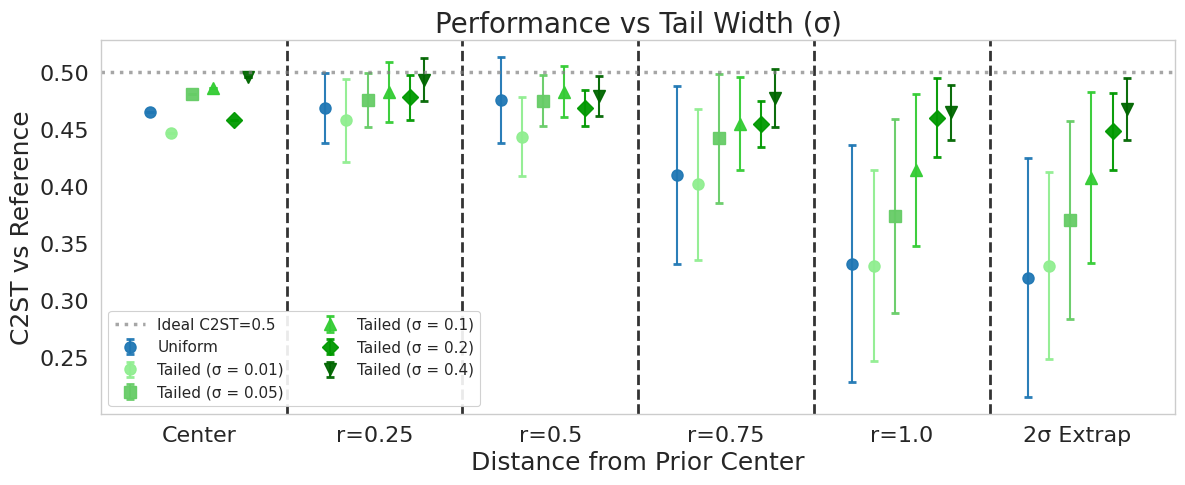

In [7]:
def plot_c2st_vs_distance_single_plot(c2st_results, figsize=(12, 5)):
    """Plot C2ST vs distance for all model configurations in a single plot"""
    distance_bins = ['center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2sigma-extrap']
    bin_labels = ['Center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2σ Extrap']
    x_positions = np.arange(len(distance_bins))

    plt.figure(figsize=figsize)

    # Define colors and markers for different configurations (narrower offsets for 6 bins)
    # Uniform baseline - single blue point
    uniform_style = {'color': '#1f77b4', 'marker': 'o', 'linestyle': '-', 'offset': -0.28}
    
    # Tailed models with different sigma values - gradient of colors
    tailed_styles = {
        0.01: {'color': '#90ee90', 'marker': 'o', 'linestyle': '--', 'offset': -0.16},
        0.05: {'color': '#66cc66', 'marker': 's', 'linestyle': '--', 'offset': -0.04},
        0.1: {'color': '#33cc33', 'marker': '^', 'linestyle': '--', 'offset': 0.08},
        0.2: {'color': '#009900', 'marker': 'D', 'linestyle': '--', 'offset': 0.20},
        0.4: {'color': '#006600', 'marker': 'v', 'linestyle': '--', 'offset': 0.28}
    }

    # Plot Uniform baseline
    model_name = 'Uniform-baseline'
    if model_name in c2st_results:
        mean_c2st = []
        std_c2st = []
        valid_x = []

        for i, bin_name in enumerate(distance_bins):
            if c2st_results[model_name][bin_name]:  # Check if bin has data
                vals = np.array(c2st_results[model_name][bin_name])
                mean_c2st.append(np.mean(vals))
                std_c2st.append(np.std(vals))
                valid_x.append(x_positions[i] + uniform_style['offset'])

        if mean_c2st:  # Only plot if we have data
            plt.errorbar(valid_x, mean_c2st, yerr=std_c2st,
                        fmt=uniform_style['marker'],
                        label='Uniform',
                        color=uniform_style['color'],
                        capsize=3, capthick=2, linewidth=0, markersize=8,
                        barsabove=True, elinewidth=1.5, alpha=0.95)

    # Plot Tailed models
    for sigma in [0.01, 0.05, 0.1, 0.2, 0.4]:
        model_name = f'Tailed-σ={sigma}'
        if model_name in c2st_results:
            mean_c2st = []
            std_c2st = []
            valid_x = []

            for i, bin_name in enumerate(distance_bins):
                if c2st_results[model_name][bin_name]:  # Check if bin has data
                    vals = np.array(c2st_results[model_name][bin_name])
                    mean_c2st.append(np.mean(vals))
                    std_c2st.append(np.std(vals))
                    valid_x.append(x_positions[i] + tailed_styles[sigma]['offset'])

            if mean_c2st:  # Only plot if we have data
                style = tailed_styles[sigma]
                plt.errorbar(valid_x, mean_c2st, yerr=std_c2st,
                            fmt=style['marker'],
                            label=f'Tailed (σ = {sigma})',
                            color=style['color'],
                            capsize=3, capthick=2, linewidth=0, markersize=8,
                            barsabove=True, elinewidth=1.5, alpha=0.95)

    # Add vertical dashed lines between distance bins
    for i in range(len(x_positions) - 1):
        separator_x = (x_positions[i] + x_positions[i + 1]) / 2
        plt.axvline(separator_x, color='black', linestyle='--', linewidth=2.0, alpha=0.8, zorder=0)

    plt.axhline(0.5, color='gray', linestyle=':', linewidth=2.5, label='Ideal C2ST=0.5', alpha=0.7)
    plt.xticks(x_positions, bin_labels, fontsize=14)
    plt.xlabel('Distance from Prior Center', fontsize=18)
    plt.ylabel('C2ST vs Reference', fontsize=18)
    plt.title('Performance vs Tail Width (σ)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid(False)
    plt.legend(fontsize=11, loc='best', ncol=2, framealpha=0.9)
    plt.tight_layout()

    return plt.gcf()

# Create the single plot version
fig = plot_c2st_vs_distance_single_plot(c2st_results)
os.makedirs('experiment-figures', exist_ok=True)
plt.savefig('experiment-figures/c2st-vs-distance-by-sigmas.pdf', dpi=300, bbox_inches='tight')
print("Saved: experiment-figures/c2st-vs-distance-by-sigmas.pdf")
plt.show()